In [1]:
import os
import sys
import warnings

os.chdir("../..")
sys.path.append("../../")
warnings.filterwarnings("ignore")

# Simulate spatial transcriptomic data

## Introduction

In this example, we show how to use scDesign3Py to simulate the spot-resolution spatial data, which each spot is a mix of cells from different cell types.

## Import packages and Read in data

### import pacakges

In [2]:
import anndata as ad
import pandas as pd
import numpy as np
import scDesign3Py

import cell2location

The R project used is located at /home/ld/mambaforge/envs/cell2loc/lib/R


### Read in the reference data

The paired scRNA-seq and spatial data were used in [CARD](https://www.nature.com/articles/s41587-022-01273-7). We pre-select the top cell-type marker genes.

In [3]:
MOBSC_exp = ad.read_h5ad("data/MOBSC.h5ad")
MOBSP_exp = ad.read_h5ad("data/MOBSP.h5ad")

In [4]:
MOBSC_exp

AnnData object with n_obs × n_vars = 12640 × 182
    obs: 'cellType', 'sampleInfo', 'sizeFactor', 'cell_type'
    var: 'rownames.count.'

In [5]:
MOBSP_exp

AnnData object with n_obs × n_vars = 278 × 182
    obs: 'spatial1', 'spatial2'
    var: 'name'

In [6]:
cell_type = MOBSC_exp.obs["cellType"].unique()

## Simulation

We first use scDesign3Py to estimate the cell-type reference from scRNA-seq data.

In [7]:
mobsc = scDesign3Py.scDesign3(n_cores=3,parallelization="pbmcmapply")
mobsc.set_r_random_seed(123)
MOBSC_data = mobsc.construct_data(
    anndata=MOBSC_exp,
    default_assay_name="counts",
    celltype="cell_type",
    corr_formula="1"
)
MOBSC_marginal = mobsc.fit_marginal(  
    mu_formula = "cell_type",
    sigma_formula = "cell_type",
    family_use="nb",
    usebam=False
)
MOBSC_copula = mobsc.fit_copula()
MOBSC_para = mobsc.extract_para()
MOBSC_newcount = mobsc.simu_new()

  |=======================================================| 100%, Elapsed 02:55


R[write to console]: Convert Residuals to Multivariate Gaussian



  |=======================================================| 100%, Elapsed 00:28


R[write to console]: Converting End

R[write to console]: Copula group 1 starts



  |=======================================================| 100%, Elapsed 00:14


R[write to console]: Use Copula to sample a multivariate quantile matrix

R[write to console]: Sample Copula group 1 starts



  |=======================================================| 100%, Elapsed 00:03


In [8]:
mobsp = scDesign3Py.scDesign3(n_cores=3,parallelization="pbmcmapply")
mobsp.set_r_random_seed(123)
MOBSP_data = mobsp.construct_data(
    anndata=MOBSP_exp,
    default_assay_name="counts",
    spatial=["spatial1", "spatial2"],
    corr_formula="1"
)
MOBSP_marginal = mobsp.fit_marginal(  
    mu_formula = "s(spatial1, spatial2, bs = 'gp', k = 50, m = c(1, 2, 1))",
    sigma_formula = "1",
    family_use="nb",
    usebam=False
)
MOBSP_copula = mobsp.fit_copula()
MOBSP_para = mobsp.extract_para()

  |=======================================================| 100%, Elapsed 00:40


R[write to console]: Convert Residuals to Multivariate Gaussian



  |=======================================================| 100%, Elapsed 00:07


R[write to console]: Converting End

R[write to console]: Copula group 1 starts



  |=======================================================| 100%, Elapsed 00:09


## Deconvolution

Now we get the fitted models for scRNA-seq and spatial data. We need to extract their mean parameters (i.e., expected expression values).

In [15]:
MOBSC_sig_matrix = pd.DataFrame(index = MOBSC_para["mean_mat"].columns)
for t in cell_type:
    cell = MOBSC_exp.obs[MOBSC_exp.obs["cell_type"]==t].index
    MOBSC_sig_matrix[t] = MOBSC_para["mean_mat"].loc[cell,:].mean().T
mixture_file = ad.AnnData(MOBSP_para["mean_mat"])
mixture_file.X = np.round(mixture_file.X)

We use [cell2location](https://cell2location.readthedocs.io/en/latest/) to decompose each spot’s expected expression into cell-type proportions. This step is to set the true cell-type proportions. Please note you can also use other decomposition methods or set the proportion mannully if you have your own design.

In [16]:
cell2location.models.Cell2location.setup_anndata(adata=mixture_file)
mod = cell2location.models.Cell2location(
    adata = mixture_file,
    cell_state_df=MOBSC_sig_matrix,
)
mod.train(max_epochs=1000)
mixture_file = mod.export_posterior(mixture_file, sample_kwargs={"num_samples":1000, "batch_size":mod.adata.n_obs,"use_gpu":True})

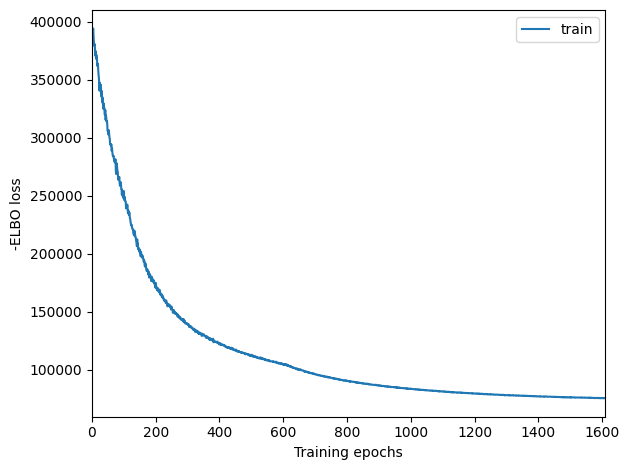

In [76]:
mod.plot_history(0)

Then we can simulate new spatial data where each spot is the sum of 50 cells/5 (therefore on average 10 cells per spot). Increasing the number of cells will make the spatial data smoother (closer to the expected spatial expression).

In [69]:
abundance = mixture_file.obsm['q05_cell_abundance_w_sf']
abundance.columns = cell_type
percent = abundance.div(abundance.sum(axis=1), axis=0)

In [142]:
# simu single cell data
simu_data = ad.AnnData(X=MOBSC_newcount,obs=MOBSC_exp.obs)

# simu mixture data
mixture = []
for spot in MOBSP_exp.obs_names:
    n = 50
    count = pd.Series(0,index=MOBSC_exp.var_names)
    for t in cell_type:
        tmp = simu_data[simu_data.obs["cell_type"]==t, ]
        index = tmp.obs.sample(n=n).index
        count_t = MOBSC_newcount.loc[index, ].sum() * percent.loc[spot,t]
        count = count + count_t
    count.name = spot
    mixture.append(count)
mixture = pd.concat(mixture,axis=1).T
mixture = mixture / 5
mixture = np.ceil(mixture)

simu_mixture = ad.AnnData(X=mixture, obs=MOBSP_exp.obs)

## Visualization

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

We can visualzie the proportions by pie-chart.

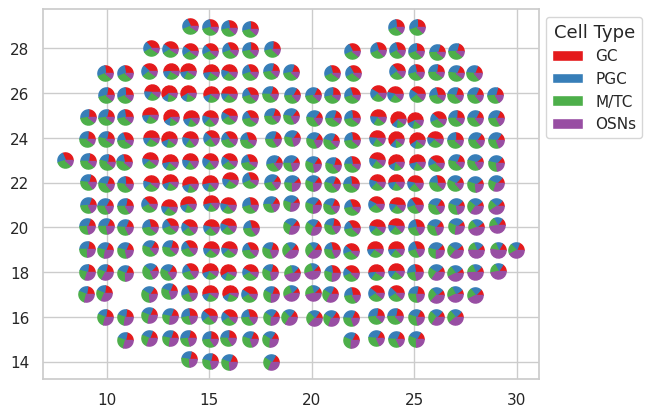

In [109]:
sns.set(style="whitegrid")

def drawPieMarker(xs, ys, ratios, sizes, colors):
    markers = []
    previous = 0
    # calculate the points of the pie pieces
    for color, ratio in zip(colors, ratios):
        this = 2 * np.pi * ratio + previous
        x  = [0] + np.cos(np.linspace(previous, this, 10)).tolist() + [0]
        y  = [0] + np.sin(np.linspace(previous, this, 10)).tolist() + [0]
        xy = np.column_stack([x, y])
        previous = this
        markers.append({'marker':xy, 's':np.abs(xy).max()**2*np.array(sizes), 'facecolor':color})

    # scatter each of the pie pieces to create pies
    for marker in markers:
        ax.scatter(xs, ys, **marker)

colors = ["#e41a1c","#377eb8","#4daf4a","#984ea3"]

fig, ax = plt.subplots()

for spot in MOBSP_exp.obs_names:
    drawPieMarker(xs=MOBSP_exp.obs["spatial1"][spot],
                ys=MOBSP_exp.obs["spatial2"][spot],
                ratios=percent.loc[spot,:].to_list(),
                sizes=120,
                colors=colors
                )

legend_elements = [Patch(facecolor=colors[i], label=cell_type[i]) for i in range(len(cell_type))]
legend = plt.legend(handles=legend_elements,loc='upper left', bbox_to_anchor=(1, 1))
legend.set_title('Cell Type', prop={'size': 13})

plt.show()

We can also check the simulated results. We use one cell-type marker genes as the example.

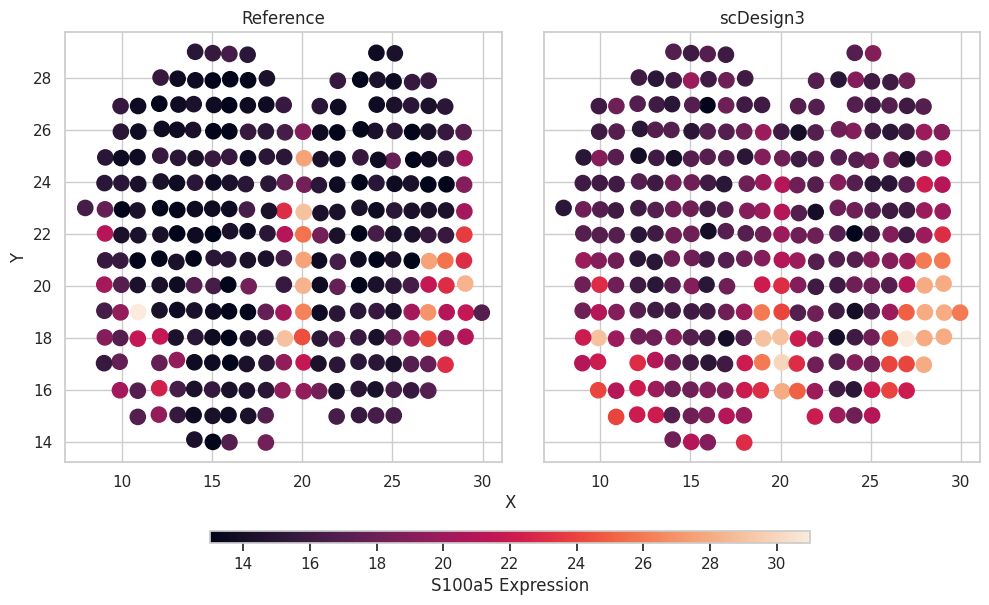

In [147]:
gene_name = "S100a5"

df = pd.concat([MOBSP_exp.obs[["spatial1","spatial2"]],simu_mixture.obs[["spatial1","spatial2"]]],axis=0)
df["Expression"] = np.concatenate([MOBSP_exp[:,gene_name].X.flatten(),simu_mixture[:,gene_name].X.flatten()])
df["Method"] = ["Reference"]*MOBSP_exp.n_obs + ["scDesign3"]*MOBSP_exp.n_obs

# plot
sns.set(style="whitegrid")
methods = df.groupby("Method")
fig, axes = plt.subplots(1, len(methods), figsize=(len(methods) * 5, 1 * 5), sharey=True, sharex=True)
fig.tight_layout()

for i, (method, exp) in enumerate(methods):
    ax = axes[i]

    scatter = ax.scatter(
        exp["spatial1"],
        exp["spatial2"],
        c=exp["Expression"],
        alpha=1,
        s=120,
    )
    ax.set_title(method)

fig.text(0.5, 0, "X", ha="center")
fig.text(0, 0.5, "Y", va="center", rotation="vertical")
position = fig.add_axes([0.2, -0.07, 0.60, 0.025])
fig.colorbar(scatter,                cax=position,
                orientation="horizontal",
                label=f"{gene_name} Expression",)
fig.show()